In [31]:
import os

print('getcwd:      ', os.getcwd())
# print('__file__:    ', __file__)

getcwd:       /tmp2/chunting/makeup/beautyGAN-tf-Implement/face-alignment-dlib


In [4]:
import os
import sys
import numpy as np
from PIL import Image
os.environ['CUDA_VISIBLE_DEVICES']='1'
import time
import cv2, dlib, argparse
from utils import extract_left_eye_center, extract_right_eye_center, get_rotation_matrix, crop_image
from matplotlib import pyplot as plt
%matplotlib inline

import pylab
import imageio

from beautyGAN_main import BeautyGAN
import tensorflow as tf

tf.reset_default_graph()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12996420846380422966
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280806708
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4282537230196570636
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:07:00.0, compute capability: 3.7"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 3372285952
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 7850684419780587547
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:84:00.0, compute capability: 3.7"
]


In [7]:
from imutils.face_utils import rect_to_bb
import imutils
from helpers import FACIAL_LANDMARKS_68_IDXS
from helpers import FACIAL_LANDMARKS_5_IDXS
from helpers import shape_to_np
import numpy as np
import cv2


class FaceDetector():
    
    def __init__(self, scale=1):
        
        self.scale = scale
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("./preTrainedModel/shape_predictor_68_face_landmarks.dat")
        self.faceAligher = FaceAligner(self.predictor, desiredLeftEye=(0.32, 0.32),desiredFaceWidth=256)
        
    def get_face(self, img):
        
#         img = cv2.imread(img_path)
        height, width = img.shape[:2]
        s_height, s_width = height//self.scale, width//self.scale
        img = cv2.resize(img, (s_width, s_height))
        
        img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dets = self.detector(img_g, 1)
        
        for rect in dets:
            # extract the ROI of the *original* face, then align the face
            # using facial landmarks
            (x, y, w, h) = rect_to_bb(rect)
            faceAligned, m = self.faceAligher.align(img, img_g, rect)
            
        return faceAligned, m
    
#modified from https://github.com/jrosebr1/imutils/blob/master/imutils/face_utils/facealigner.py
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, rect):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)
        
        #simple hack ;)
        if (len(shape)==68):
            # extract the left and right eye (x, y)-coordinates
            (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        else:
            (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
            
        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output, M
        
    

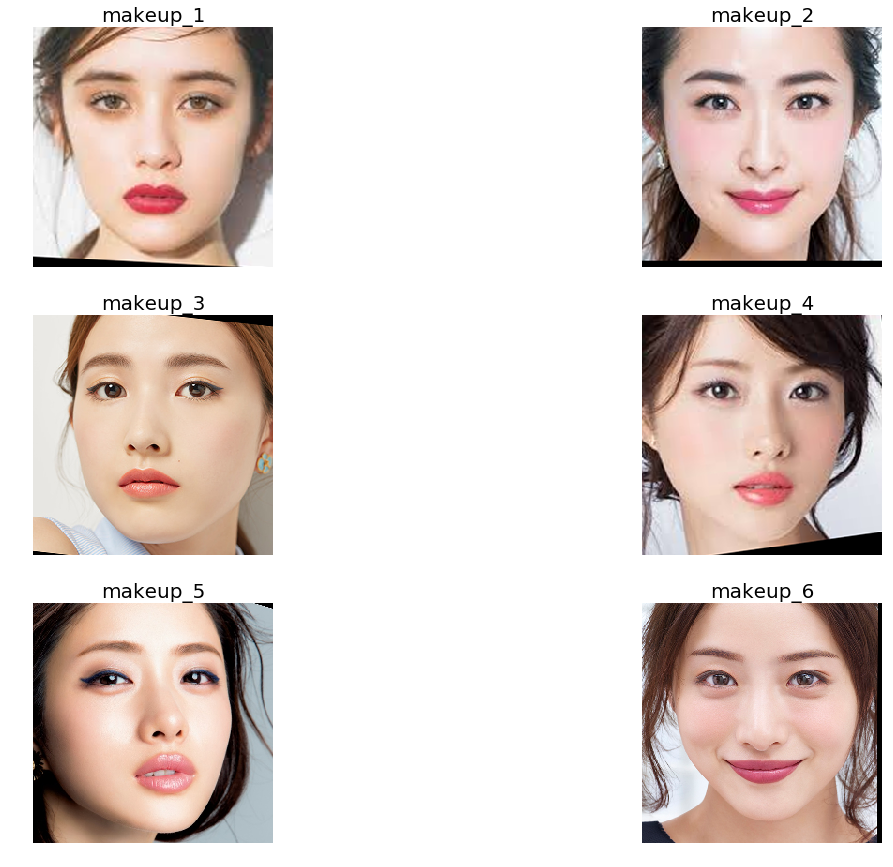

In [8]:
detector = FaceDetector()    

image1= './images.jpeg'
image2= './images2.jpeg'
image3= './images3.jpg'
image4= './images4.jpeg'
image5= './images5.jpg'
image6= './images6.png'

image1= cv2.imread('makeup/' + image1 )
image2= cv2.imread('makeup/' + image2 )
image3= cv2.imread('makeup/' + image3 )
image4= cv2.imread('makeup/' + image4 )
image5= cv2.imread('makeup/' + image5 )
image6= cv2.imread('makeup/' + image6 )

image1, m = detector.get_face(image1 )
image2, m = detector.get_face(image2 )
image3, m = detector.get_face(image3 )
image4, m = detector.get_face(image4 )
image5, m = detector.get_face(image5 )
image6, m = detector.get_face(image6 )

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
image5 = cv2.cvtColor(image5, cv2.COLOR_BGR2RGB)
image6 = cv2.cvtColor(image6, cv2.COLOR_BGR2RGB)

# ax2.imshow(cv2.cvtColor(img_tgt, cv2.COLOR_BGR2RGB))
# plt.show()

plt.figure(figsize=(20,15))

ax1 = plt.subplot2grid((3,2), (0,0))
plt.title("makeup_1", size=20)
ax1.imshow(np.squeeze(image1))
ax1.axis('off')

ax2 = plt.subplot2grid((3,2), (0,1), colspan=2)
plt.title("makeup_2", size=20)
ax2.imshow(np.squeeze(image2))
ax2.axis('off')

ax3 = plt.subplot2grid((3,2), (1,0))
plt.title("makeup_3", size=20)
ax3.imshow(np.squeeze(image3))
ax3.axis('off')

ax4 = plt.subplot2grid((3,2), (1,1), colspan=2)
plt.title("makeup_4", size=20)
ax4.imshow(np.squeeze(image4))
ax4.axis('off')

ax5 = plt.subplot2grid((3,2), (2,0))
plt.title("makeup_5", size=20)
ax5.imshow(np.squeeze(image5))
ax5.axis('off')

ax6 = plt.subplot2grid((3,2), (2,1), colspan=2)
plt.title("makeup_6", size=20)
ax6.imshow(np.squeeze(image6))
ax6.axis('off')

plt.show()

In [9]:
tf.reset_default_graph()

beautyGan = BeautyGAN(prediction=True , check_dir='checkpoints_ori')

Tensor("Model/generator/MirrorPad:0", shape=(1, 262, 262, 3), dtype=float32)
Tensor("Model/generator/MirrorPad_1:0", shape=(1, 262, 262, 3), dtype=float32)
Tensor("Model/generator/concat:0", shape=(1, 64, 64, 256), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints_ori/beautyGAN-319
restored  checkpoints_ori/beautyGAN-319


In [24]:

def get_makeup_image(input_src, input_tgt, image_name):
    
    img_tgt = cv2.imread(input_tgt )
    img_tgt = imutils.resize(img_tgt, width=800)
    tgt_face, m = detector.get_face(img_tgt )
    tgt = cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB)
    tgt = np.expand_dims(tgt,0)/ 127.5 -1
    
    img_src = cv2.imread(input_src )
    img_src = imutils.resize(img_src, width=800)
    src_face, m = detector.get_face(img_src )
    src = cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB)
    src = np.expand_dims(src,0)/ 127.5 -1

    height, width, ch = img_src.shape
    size = (width,height)
    
    _, output = beautyGan.predict(src,tgt) # src:non makeup target: makup

    output = (output + 1) * 127.5

    output = np.uint8(np.squeeze(output))


    im = cv2.invertAffineTransform(m)
    output = cv2.warpAffine(output, im, size,flags=cv2.INTER_CUBIC)

    lip_mask, eye_mask, face_mask = beautyGan.get_mask(src_face, detector.detector, detector.predictor)

    lip_mask = lip_mask.astype(np.uint8)
    face_mask = face_mask.astype(np.uint8)
    eye_mask = eye_mask.astype(np.uint8)

    kernel = np.ones((3,3),np.uint8)
    face_mask = cv2.erode(face_mask,kernel,iterations = 5)
    # face_mask = cv2.erode(face_mask,kernel,iterations = 3)

    mask = np.clip(lip_mask * 3.0+ 1.0*eye_mask + face_mask * 0.0 , 0, 255)


    mask = mask.astype(np.uint8)

    face_mask = cv2.warpAffine(mask, im, size,flags=cv2.INTER_CUBIC)
    face_mask = cv2.blur(face_mask,(10,10))


    foreground = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
    background = img_src
    alpha = np.stack([face_mask, face_mask, face_mask],-1)

    foreground = foreground.astype(float)
    background = background.astype(float)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255 


    foreground = cv2.multiply(alpha, foreground)
    background = cv2.multiply(1.0 - alpha, background)

    outImage = cv2.add(foreground, background)

    outImage = cv2.cvtColor(np.uint8(outImage), cv2.COLOR_BGR2RGB)
    
    cv2.imwrite('output/' + image_name + '.jpg', outImage)
    
    return outImage

In [25]:

def get_makeup_video(input_tgt, filename, video_name):
    
    img_tgt = cv2.imread(input_tgt )
    tgt_face, m = detector.get_face(img_tgt )
    tgt = cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB)

    tgt = np.expand_dims(tgt,0)/ 127.5 -1

    # out.release()
    cv2.destroyAllWindows() 


    frame_width,frame_height  = (800, 450)
    cap = cv2.VideoCapture(filename)
    # out = cv2.VideoWriter('out2.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    out = cv2.VideoWriter('output/'+video_name+'.mp4', fourcc, 10, (frame_width, frame_height))


    while(cap.isOpened()):

        ret, frame = cap.read()
        start = time.clock()
        if ret == True:
            # Display the resulting frame
            ret, frame = cap.read()

            img_src  = imutils.resize(frame, width=800)

            height, width, ch = img_src.shape

            size = (width,height)

            src_face, mm = detector.get_face(img_src)

            src = cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB)

            src = np.expand_dims(src,0)/ 127.5 - 1

            start = time.clock()

            _, output = beautyGan.predict(src,tgt) # src:non makeup target: makup
            end = time.clock()

            output = (output + 1) * 127.5
            output = np.uint8(np.squeeze(output))

            im = cv2.invertAffineTransform(mm)
            output = cv2.warpAffine(output, im, size,flags=cv2.INTER_CUBIC)

            lip_mask, eye_mask, face_mask = beautyGan.get_mask(src_face, detector.detector, detector.predictor)

            lip_mask = lip_mask.astype(np.uint8)
            face_mask = face_mask.astype(np.uint8)
            eye_mask = eye_mask.astype(np.uint8)

            kernel = np.ones((3,3),np.uint8)
            face_mask = cv2.erode(face_mask,kernel,iterations = 5)
            # face_mask = cv2.erode(face_mask,kernel,iterations = 3)

            mask = np.clip(lip_mask * 5.0+ 2.0*eye_mask + face_mask * 0.0 , 0, 255)


            mask = mask.astype(np.uint8)

            face_mask = cv2.warpAffine(mask, im, size,flags=cv2.INTER_CUBIC)
            face_mask = cv2.blur(face_mask,(10,10))

            foreground = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
            background = img_src
            alpha = np.stack([face_mask, face_mask, face_mask],-1)

            print(alpha.shape)
            print(background.shape)

            foreground = foreground.astype(float)
            background = background.astype(float)

            # Normalize the alpha mask to keep intensity between 0 and 1
            alpha = alpha.astype(float)/255 

            foreground = cv2.multiply(alpha, foreground)
            background = cv2.multiply(1.0 - alpha, background)

            outImage = cv2.add(foreground, background)

            outImage = cv2.cvtColor(np.uint8(outImage), cv2.COLOR_BGR2RGB)

            outImage = cv2.cvtColor(outImage, cv2.COLOR_BGR2RGB)        
            out.write(outImage)
            end = time.clock()
            print(end-start)

            # Break the loop
        else: 
            break
            cap.release()


    out.release()
    cv2.destroyAllWindows() 



    # plt.figure(figsize=(20,10))
    # plt.imshow(frame)
    # plt.axis('off')
    # plt.show()


In [26]:
# input_tgt = './makeup/images6.png'
# filename = '../test.mp4'
# video_name = 'images6'

# get_makeup_video(input_tgt, filename, video_name)

input_tgt = './makeup/images.jpeg'
input_src = 'nonmake.jpeg'
image_name = 'nonmake'

outImage = get_makeup_image(input_src, input_tgt, image_name)

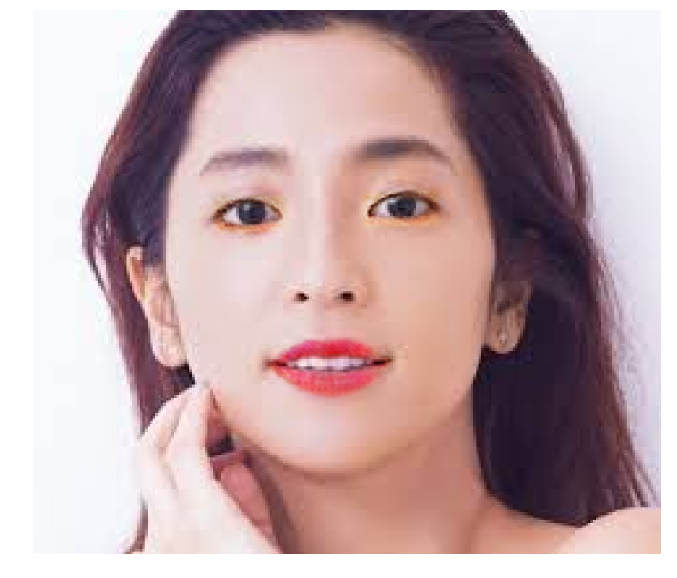

In [27]:
plt.figure(figsize=(20,10))
plt.imshow(outImage)
plt.axis('off')
plt.show()

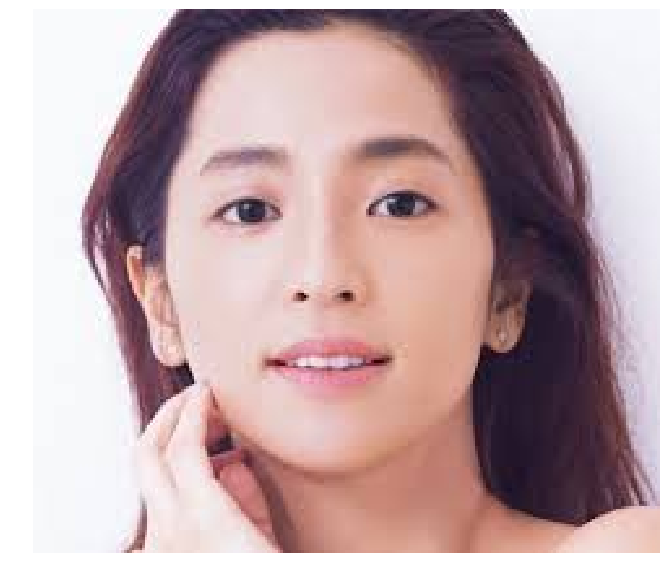

In [28]:
img_src = cv2.imread(input_src )
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_src)
plt.axis('off')
plt.show()

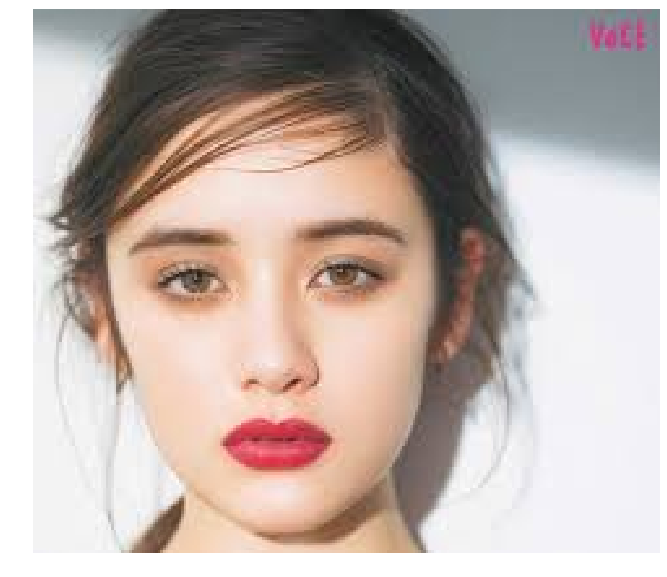

In [29]:
input_tgt = cv2.imread(input_tgt )
img_tgt = cv2.cvtColor(input_tgt, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_tgt)
plt.axis('off')
plt.show()

In [45]:
import cv2
import os

def save_frame_camera_key(device_num, dir_path, basename, ext='jpg', delay=1, window_name='frame'):
    cap = cv2.VideoCapture(device_num)

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    n = 0
    while True:
        ret, frame = cap.read()
        cv2.imshow(window_name, frame)
        key = cv2.waitKey(delay) & 0xFF
        if key == ord('c'):
            cv2.imwrite('{}_{}.{}'.format(base_path, n, ext), frame)
            n += 1
        elif key == ord('q'):
            break

    cv2.destroyWindow(window_name)


save_frame_camera_key(0, '', 'camera_capture')